<a href="https://colab.research.google.com/github/davidkubanek/Thesis/blob/main/HTS_fingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HTS Fingerprints (PubChem)
### Reproducing the HTS Fingerprints for compounds in the PubChem BioAssay database based on (Helal et al., 2016)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
plt.rcParams["font.family"] = "Palatino"
from scipy.sparse import dok_matrix
from scipy.sparse import save_npz, load_npz
import torch
from tqdm import tqdm
import os


### If run in colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print("CUDA is available and activated.")
else:
    print("CUDA is not available.")


Mounted at /content/drive
CUDA is available and activated.


In [36]:
class DataProcess:
    '''
    Class for processing the bioassay data downloaded from PubChem and generating HTS Fingerprints (HTSFP) as described in Helal et al., 2016.
    '''
    def __init__(self, directory, cut_off_assays, cut_off_compounds, range='all', z_type = 'mean'):
        '''
        directory: path to the directory where the bioassay data is stored
        cut_off_assays: minimum number of assays a compound must appear in to be considered valid
        cut_off_compounds: minimum number of compounds an assay must contain to be considered valid
        range: number of assays to process, 'all' to process all assays
        z_type: type of Z-score to calculate, 'mean' for mean and standard deviation, 'median' for median and median absolute deviation
        '''

        self.directory = directory
        self.cut_off_assays = cut_off_assays
        self.cut_off_compounds = cut_off_compounds

        # read the AIDs from the files actually present in the directory
        self.read_AIDs_files()

        if range == 'all':
            self.range = len(self.AIDs)
        elif range > len(self.AIDs):
            self.range = len(self.AIDs)
        else:
            self.range = range
        
        self.z_type = z_type


    def read_AIDs(self):
        '''
        Read the AIDs assay identifiers from the file with AID numbers of the target assays from PubChem
        (not what is actually present in the directory but what we wish to download from PubChem matching the search criteria)
        Save a list of AIDs as an attribute of the class.
        '''
        # path to the file with AID numbers of the downloaded assays from PubChem
        AID_path = self.directory + '/info/pcassay_result_AID.txt'
        with open(AID_path, 'r') as file:
            lines = file.read().splitlines()

        # convert to integers
        self.AIDs = list(map(int, lines))

    def read_AIDs_files(self):
        '''
        Read the AIDs assay identifiers from the files actually present in the directory
        Save a list of AIDs as an attribute of the class.
        '''
        # check what AIDs files exist in the directory
        files = os.listdir(directory)
        # find pattern AID_ in the file names
        pattern = re.compile(r'AID_\d+\.csv')
        # find all files that match the pattern
        files = [file for file in files if pattern.match(file)]
        # extract the AIDs from the file names
        self.AIDs = [int(file[4:-4]) for file in files]


    # import the bioassay data downloaded from PubChem
    def load_bioassay_data(self, AID):
        ''''
        Load the bioassay data from the csv file for a given AID.
        Return a DataFrame with the data.
        '''
        # import csv file from path
        path = self.directory + f'/AID_{AID}.csv'
        df = pd.read_csv(path, sep=',', header=0, dtype={'PUBCHEM_CID': 'Int64', 'PUBCHEM_EXT_DATASOURCE_SMILES': str, 'PUBCHEM_ACTIVITY_OUTCOME': str,'Compound QC':str}, low_memory=False)
        # drop the first column
        df = df.drop(df.columns[0], axis=1)
        # drop rows with NaN values in the 'PUBCHEM_SID' column
        df = df.dropna(subset=['PUBCHEM_CID'])
        # reset the index
        df = df.reset_index(drop=True)

        return df

    def find_valid_compounds(self):
        '''
        Filter the compounds to only include those that appear in at least 'cut_off_assays' number of assays.
        Returns a list of valid SMILES.
        '''

        # create a Counter object to hold the counts of each SMILES
        counter = Counter()
        # dictionary to hold the number of compounds per assay
        self.compounds_per_assay = {}

        # go through each bioassay and count the number of times each CID appears
        for AID in tqdm(self.AIDs[:self.range], desc='Counting compounds in each assay', total=self.range):
            df = self.load_bioassay_data(AID)

            # check if the 'CID' column exists in the DataFrame
            assert 'PUBCHEM_EXT_DATASOURCE_SMILES' in df.columns, f"DataFrame for AID {AID} does not have a 'SMILES' column"
            # update the counter with the SMILES in the 'SMILES column
            counter.update(df['PUBCHEM_EXT_DATASOURCE_SMILES'])

            # count the number of unique compounds in the filtered DataFrame
            self.compounds_per_assay[AID] = df['PUBCHEM_EXT_DATASOURCE_SMILES'].nunique()

        # save the number of unique compounds
        self.smiles = len(counter)

        print('Finding valid compounds...')
        # filter the counter to only include SMILES that appear in at least 'cut_off_assays' number of assays
        filtered_counter = {smiles: count for smiles, count in counter.items() if count >= self.cut_off_assays}

        # list of SMILES that appear in at least 'cut_off_assays' number of assays
        self.valid_smiles = list(filtered_counter.keys())



    def filter_assays(self):
        '''
        Filter the invalid compounds from each assay.
        Filter the assays to only include those that contain at least 'cut_off_compounds' number of compounds and have a primary activity column.
        Convert the primary activity column to a Z-score.
        Save the number of valid compounds per assay as an attribute of the class.
        Save the valid assays AIDs as an attribute of the class.
        Save the primary activity column names as an attribute of the class.
        Save the filtered assays to new CSV files.
        '''
        self.valid_compounds_per_assay = {}
        self.valid_AIDs = []
        self.primary_activity_columns = {}
        self.mean_z_score = []
        self.mean_z_score_mad = []

        # go through each bioassay file and discard rows with SMILES that are not in 'valid_smiles'
        for AID in tqdm(self.AIDs[:self.range], desc='Filtering assays', total=self.range):
            
            df = self.load_bioassay_data(AID)
            # filter the DataFrame to only include rows with a valid SMILES
            df = df[df['PUBCHEM_EXT_DATASOURCE_SMILES'].isin(self.valid_smiles)]

            # count the number of unique compounds in the filtered DataFrame
            unique_compounds = df['PUBCHEM_EXT_DATASOURCE_SMILES'].nunique()
            self.valid_compounds_per_assay[AID] = unique_compounds

            # only write the filtered assay to a new CSV file if it contains enough unique compounds and has a primary activity column
            if unique_compounds >= self.cut_off_compounds:
                # check if any of the primary activity columns exists in the DataFrame, primary activity can be different for each assay type
                primary_found, primary_activity_column = self.find_primary_activity_column(df)
                # save the primary activity column name
                self.primary_activity_columns[AID] = primary_activity_column
                if primary_found:
                    
                    self.valid_AIDs.append(AID)

                    # replace NaN values in primary activity column with 0
                    df[primary_activity_column] = df[primary_activity_column].fillna(0)

                    # calculate the Z-score for each compound in the assay based on the primary activity column
                    df = self.get_Z_score(df, primary_activity_column)

                    # check if the primary activity column is empty
                    if df[primary_activity_column].isnull().values.any():
                        print(f'WARNING: primary activity column {primary_activity_column} for AID {AID} contains NaN values')
                        # replace NaN values with 0
                        # df[primary_activity_column] = df[primary_activity_column].fillna(0)
                        print(df[primary_activity_column])
                    
                    # save mean z score for each assay
                    self.mean_z_score.append(df['Z_score'].mean())
                    self.mean_z_score_mad.append(df['Z_score_mad'].mean())

                    # rename the 'PUBCHEM_EXT_DATASOURCE_SMILES' column to 'SMILES'
                    df = df.rename(columns={'PUBCHEM_EXT_DATASOURCE_SMILES': 'SMILES'})

                    # write the filtered DataFrame to a new CSV file with only the columns needed further: Z-scores and SMILES
                    df[['PUBCHEM_CID', 'SMILES', 'Z_score', 'Z_score_mad']].to_csv(self.directory + f'/filtered/AID_{AID}.csv', index=False)
        print('SUCCESS')

    def print_columns(self):
        '''
        Print the column names of the assays.
        '''
        for AID in self.AIDs[:self.range]:
            df = self.load_bioassay_data(AID)
            # print the column names of the assay
            print(df.columns)


    def find_primary_activity_column(self, df):
        '''
        Find the primary activity column in the DataFrame.
        - First check if the column name matches the regular expression pattern for "Inhibition at X" or "Activation at X".
        - If no match is found, check for additional primary activity columns.
        - If no additional primary activity column is found, return the generic primary activity column.
        Return a tuple with a boolean value indicating if a primary activity column was found and the name of the primary activity column.
        '''

        if 'PUBCHEM_ACTIVITY_SCORE' not in df.columns:
            return False, None

        # patterns of primary activity column names found for different assay types
        # compile the regular expression pattern for both "Inhibition at X" and "Activation at X"
        pattern = re.compile(r'(Inhibition|Activation) at \d+')
        # compile the regular expression pattern for '%Activity at X uM_Norm'
        pattern_2 = re.compile(r'%Activity at \d+ uM_Norm')
        # compile the regular expression pattern for 'Activity_Normalized at X'
        pattern_3 = re.compile(r'Activity_Normalized at \d+ uM')
        # compile the regular expression pattern for 'REPLICATE_A_ACTIVITY_SCORE_X'
        pattern_4 = re.compile(r'REPLICATE_A_ACTIVITY_SCORE_\d+')
        # compile the regular expression pattern for all other variations of 'Activity'
        pattern_5 = re.compile(r'%Activity(?:_Normalized)?(?:_Normalized)? at \d+(?:\.\d+)? uM|Activity at \d+(?:\.\d+)? uM|%Activation(?:_Normalized)? at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all other variations of 'Ratio:Normalized at XXX uM'
        pattern_6 = re.compile(r'Ratio:Normalized at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all other variations of '%Activity_Corrected at XXX uM'
        pattern_7 = re.compile(r'%Activity_Corrected at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all other variations of '%Inhibition at XX uM'
        pattern_8 = re.compile(r'%Inhibition at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all that include 'Max_Response'
        pattern_9 = re.compile(r'Max_Response')

        # check each column for a match to the pattern
        for column in df.columns:
            # check that the data column contains some values
            if df[column].isnull().values.all():
                continue
            
            # check for basic primary activity columns
            elif column in ['Max_Response', 'Max_response', 'Percent Activity', '%Inhibition_%Positive', 'Inhibition', 'PERCENT_RESPONSE', 'REPLICATE_A_ACTIVITY_SCORE', 'BScore_intRatio ', 'PERCENT_INHIBITION', 'ratioBScore', 
                            'Percentage', 'BScoreRatio', 'RESPONSE', 'Ratio: Corrected', 'RatioResponse', 'Activity', 'Percent of Activity', 'Bscore_Ratio']:
                return True, column

            # if no match was found, check if the column name matches any of the specific patterns
            elif pattern.match(column) or pattern_2.match(column) or pattern_3.match(column) or pattern_4.match(column) or pattern_5.match(column) or pattern_6.match(column) or pattern_7.match(column) or pattern_8.match(column) or pattern_9.match(column):
                return True, column
        

        # if no primary activity column was found, return the generic primary activity column
        return True, 'PUBCHEM_ACTIVITY_SCORE'

    def get_Z_score(self, df, primary_activity_column):
        '''
        Given the primary activity column, calculate the Z-score for each compound in the assay.
            - type='mean': calculate the Z-score using the mean and standard deviation
            - type='median': calculate the Z-score using the median and median absolute deviation.
        Return the DataFrame with the Z-score column added.
        '''

        # calculate the mean and standard deviation of the primary activity column
        # convert the column to float
        df[primary_activity_column] = df[primary_activity_column].astype(float)


        # if self.z_type == 'mean':
        #     mean = df[primary_activity_column].mean()
        #     std = df[primary_activity_column].std()

        #     # calculate the Z-score for each compound
        #     df['Z_score'] = (df[primary_activity_column] - mean) / std
        # elif self.z_type == 'median':
        #     # calculate the modified Z-score for each compound
        #     df['Z_score'] = self.modified_z_score(df[primary_activity_column])

    
        mean = df[primary_activity_column].mean()
        std = df[primary_activity_column].std()

        # calculate the Z-score for each compound
        df['Z_score'] = (df[primary_activity_column] - mean) / std
    
        # calculate the modified Z-score for each compound
        df['Z_score_mad'] = self.modified_z_score(df[primary_activity_column])
            
        return df


    def median_absolute_deviation(self, df):
        '''
        Calculate the median absolute deviation of a dataset.
        '''
        median = df.median()
        absolute_deviation = np.abs(df - median)
        mad = np.median(absolute_deviation)
        return mad

    def modified_z_score(self, df):
        '''
        Calculate the modified Z-score of a dataset.
        '''
        median = df.median()
        mad = self.median_absolute_deviation(df)
        # The constant factor 0.6745 is a scaling factor to make the Modified Z-Score comparable to a standard z-score for normally distributed data
        modified_z_scores = 0.6745 * (df - median) / mad
        return modified_z_scores


    def statistics(self):
        print('-------------------------------------')
        print('# compounds before filtering:', self.smiles)
        print('# compounds after filtering:', len(self.valid_smiles))
        print('# assays before filtering:', len(self.AIDs[:self.range]))
        print('# assays after filtering:', len(self.valid_AIDs))
        print('-------------------------------------')

        # plot the number of compounds per assay histogram
        plt.hist(self.compounds_per_assay.values(), bins=100)
        plt.xlabel('Number of compounds per assay')
        plt.ylabel('Number of assays')
        plt.title('Number of compounds per assay(after filtering)')
        # show ylabel integers
        plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
        plt.savefig(self.directory+'/info/compounds_per_assay.png', dpi=500)
        plt.show()

        # plot the primary activity column histogram
        primary_activity_columns_clean = self.primary_activity_histogram()
        plt.hist(primary_activity_columns_clean.values(), bins=100)
        plt.xlabel('Primary activity column')
        # make the xlabels angled
        plt.xticks(rotation=45)
        plt.ylabel('Number of assays')
        plt.title('Primary activity types')
        plt.savefig(self.directory+'/info/primary_activity.png', dpi=500)
        plt.show()

    def primary_activity_histogram(self):

        # Regular expressions for 'Inhibition X' and 'Activation X'
        pattern_inhibition = re.compile(r'Inhibition at \d+')
        pattern_activation = re.compile(r'Activation at \d+')
        # compile the regular expression pattern for '%Activity at X uM_Norm'
        pattern_2 = re.compile(r'%Activity at \d+ uM_Norm')
        # compile the regular expression pattern for 'Activity_Normalized at X'
        pattern_3 = re.compile(r'Activity_Normalized at \d+ uM')
        # compile the regular expression pattern for 'REPLICATE_A_ACTIVITY_SCORE_X'
        pattern_4 = re.compile(r'REPLICATE_A_ACTIVITY_SCORE_\d+')
        # compile the regular expression pattern for all other variations of 'Activity'
        pattern_5 = re.compile(r'%Activity(?:_Normalized)?(?:_Normalized)? at \d+(?:\.\d+)? uM|Activity at \d+(?:\.\d+)? uM|%Activation(?:_Normalized)? at \d+(?:\.\d+)? uM')

        # Create a new dictionary
        primary_activity_columns_clean = {}

        # Iterate over the items in dict1
        for key, value in self.primary_activity_columns.items():
            if value == 'PUBCHEM_ACTIVITY_SCORE':
                primary_activity_columns_clean[key] = 'Pubchem Activity Score'
            elif value == 'Max_Response' or value == 'Max_response':
                primary_activity_columns_clean[key] = 'Max Response'
            # If the value matches the 'Inhibition X' pattern, replace it with 'Inhibition'
            elif pattern_inhibition.match(value):
                primary_activity_columns_clean[key] = 'Inhibition'
            # If the value matches the 'Activation X' pattern, replace it with 'Activation'
            elif pattern_activation.match(value):
                primary_activity_columns_clean[key] = 'Activation'
            elif pattern_2.match(value) or pattern_3.match(value) or pattern_5.match(value):
                primary_activity_columns_clean[key] = '%Activity'
            elif pattern_4.match(value):
                primary_activity_columns_clean[key] = 'Replicate Activity Score'
            # Otherwise, copy the value as is
            else:
                primary_activity_columns_clean[key] = value

        return primary_activity_columns_clean


    def compare_to_Helal(self):
        '''
        Compare the valid AIDs to the valid AIDs used by Helal et al.
        '''
        # Load the Excel file with the AIDs used by Helal et al.
        df = pd.read_excel(self.directory+'/info/Helal_AIDs.xlsx')

        # Get the 'AID' column data into a list
        self.AIDs_Helal = df['AID'].tolist()

        # Convert the lists to sets
        set1 = set(self.AIDs_Helal)
        set2 = set(self.valid_AIDs)

        # Find the intersection (overlap)
        overlap = set1 & set2
        print('-------------------------------------')
        print('# Helal valid AIDs:', len(set1), '| # my valid AIDs:', len(set2))
        print("# overlap:", len(overlap))
        print('-------------------------------------')

    def create_activity_matrix_eff(self):


        # A list of all your CSV files
        # First, we'll need to concatenate all the csv files into a single DataFrame
        # For this, place all assay csv files into a list
        assay_files = [f'AID_{AID}.csv' for AID in self.valid_AIDs]

        # Create a dictionary to map each CID to a unique row index
        smiles_to_row = {}
        next_row = 0

        # Initialize an empty sparse matrix in the Dictionary of Keys (DOK) format
        # This format allows efficient incremental building of the sparse matrix
        # The initial shape (1, len(csv_files)) is arbitrary and will be resized later
        matrix = dok_matrix((1, len(assay_files)), dtype=np.float32)

        # Process each CSV file
        for aid, file in tqdm(enumerate(assay_files), desc='Building matrix from filtered assay files', total=len(assay_files)):
            # Load the CSV file
            df = pd.read_csv(self.directory+'/filtered/'+file)

            # Process each SMILES in the CSV file
            for i, row in df.iterrows():
                smiles = row['SMILES']
                if self.z_type == 'mean':
                    z_score = row['Z_score']
                elif self.z_type == 'median':
                    z_score = row['Z_score_mad']

                # Map the SMILES to a unique row index, if it hasn't been mapped already
                if smiles not in smiles_to_row:
                    smiles_to_row[smiles] = next_row
                    next_row += 1

                    # Resize the sparse matrix to accommodate the new row, if necessary
                    if next_row > matrix.shape[0]:
                        matrix.resize((next_row, matrix.shape[1]))
                # else if the SMILES has already been mapped, average the Z-scores
                else:
                    # Get the row index for this SMILES
                    row_index = smiles_to_row[smiles]
                    # Calculate the average of the old and new Z-score
                    z_score = (matrix[row_index, aid] + z_score) / 2

                # Get the row index for this SMILES
                row_index = smiles_to_row[smiles]
                # Add the Z-score to the sparse matrix
                matrix[row_index, aid] = z_score

        print('Processing activity matrix...')
        # Now that we've finished building the sparse matrix, we can save it to a file
        save_npz(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.npz', matrix.tocoo())

        # load the .npz matrix
        matrix = load_npz(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.npz')
        # convert to a DataFrame
        matrix_df = pd.DataFrame.sparse.from_spmatrix(matrix)
        # rename the columns to AIDs
        matrix_df.columns = self.valid_AIDs
        # add a 'SMILES' column to beginning of the DataFrame
        matrix_df.insert(0, 'SMILES', list(smiles_to_row.keys()))
        # move the 'SMILES' column to the beginning of the DataFrame

        # save the DataFrame to a csv file
        matrix_df.to_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv', index=False)

        # save the smiles column as a csv file
        matrix_df['SMILES'].to_csv(self.directory+f'/final/smiles_{str(self.range)}_{self.z_type}.csv', index=False)

        print('SUCCESS')

    def filter_promiscuous_compounds(self, z_threshold, hit_threshold):
        '''
        Filter promiscuous compounds (frequent hitters) from the activity matrix.
            Frequent hitters are compounds that are active in a large number of assays and bias the data.

        '''
        print('Filtering promiscuous compounds...')
        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv')
        # for each compound, count the number of assays it is highly active in
        self.num_active = (matrix_df.iloc[:, 1:] > z_threshold).sum(axis=1)
        # for each compound count the number of assays it has been tested in
        self.num_tested = (matrix_df.iloc[:, 1:] != 0).sum(axis=1)
        # calculate the assay hit rate
        self.hit_rate = self.num_active / self.num_tested
        # filter the compounds to only include those with a hit rate below the threshold
        filtered_df = matrix_df[self.hit_rate < hit_threshold]
        print('No. of promiscuous compounds filtered:', matrix_df.shape[0] - filtered_df.shape[0], f'({round((matrix_df.shape[0] - filtered_df.shape[0])/matrix_df.shape[0]*100.2)}% of compounds)')
        # save the filtered DataFrame to a csv file
        filtered_df.to_csv(f'Data/activity_matrix_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        # save the smiles column as a csv file
        matrix_df['SMILES'].to_csv(self.directory+f'/final/smiles_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        print('SUCCESS')

    def filter_inactive_compounds(self, z_threshold=0.5):
        '''
        Filter inactive compounds from the activity matrix.
            Inactive are compounds that have z-score below a threshold across all measured assays.

        '''
        print('Filtering inactive compounds...')
        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_filtered_{str(self.range)}_{self.z_type}.csv')
        # for each compound, count the number of assays it is at least slightly active in
        num_active = (abs(matrix_df.iloc[:, 1:]) > z_threshold).sum(axis=1)
        # check the number of assays in which no hits were found
        print(f'No. of inactive compounds filtered: {len(num_active[num_active == 0])} ({round(len(num_active[num_active == 0])/matrix_df.shape[0]*100,2)} % of compounds)')
        # filter out compounds that are inactive in all assays
        matrix_df = matrix_df[num_active != 0]
        # save the filtered DataFrame to a csv file
        matrix_df.to_csv(self.directory+f'/final/activity_matrix_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        # save the smiles column as a csv file
        matrix_df['SMILES'].to_csv(self.directory+f'/final/smiles_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        print('SUCCESS')

    def check_correct(self):
        '''
        Check if the activity matrix was created correctly.
        '''

        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv')

        print('_____________________________________')
        # proportion of zero values
        print("Proportion of zero values in the matrix:", (matrix_df == 0).sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1]))
        # proportion of NaN values
        print("Proportion of NaN values in the matrix:", matrix_df.isna().sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1]))
        print('--------------------------------')
        # Sanity check for data types
        print("Data types in the matrix:\n", matrix_df.dtypes)
        print('--------------------------------')
        # Sanity check for dimensions
        print("Dimensions of the matrix:", matrix_df.shape)
        print('Dimensions expected: ', f'({len(self.valid_smiles)}, {len(self.valid_AIDs)+1})')
        print('--------------------------------')
        # Statistical analysis
        print("Statistics for each AID column:\n", matrix_df.describe())
        print('_____________________________________')

    def check_duplicate_smiles(self):
        '''
        Checks how many duplicate SMILES rows are in the activity matrix.
        '''
        print('_____________________________________')
        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv')

        # Check for duplicate CIDs
        duplicate_smiles = matrix_df['SMILES'].duplicated()

        # Count the number of duplicates
        num_duplicates = duplicate_smiles.sum()

        # Print the number of duplicate CIDs
        print("Number of duplicate SMILES:", num_duplicates)

        # If you want to see the duplicated rows:
        print("Duplicated rows:")
        print(matrix_df[matrix_df['SMILES'].duplicated(keep=False)])
        print('_____________________________________')
        return duplicate_smiles

    def save(self):
        '''
        Save the class attributes to a file.
        '''
        with open(self.directory + '/info/valid_AIDs.txt', 'w') as file:
            for AID in self.valid_AIDs:
                file.write(str(AID) + '\n')

        with open(self.directory + '/info/valid_smiles.txt', 'w') as file:
            for smiles in self.valid_smiles:
                file.write(str(smiles) + '\n')

        with open(self.directory + '/info/valid_compounds_per_assay.txt', 'w') as file:
            for AID, count in self.valid_compounds_per_assay.items():
                file.write(str(AID) + '\t' + str(count) + '\n')

        with open(self.directory + '/info/primary_activity_columns.txt', 'w') as file:
            for AID, column in self.primary_activity_columns.items():
                file.write(str(AID) + '\t' + str(column) + '\n')

        with open(self.directory + '/info/compounds_per_assay.txt', 'w') as file:
            for AID, count in self.compounds_per_assay.items():
                file.write(str(AID) + '\t' + str(count) + '\n')


    def load(self):
        '''
        Load the class attributes from a file.
        '''
        with open(self.directory + '/info/valid_AIDs.txt', 'r') as file:
            lines = file.read().splitlines()
        self.valid_AIDs = list(map(int, lines))

        with open(self.directory + '/info/valid_smiles.txt', 'r') as file:
            lines = file.read().splitlines()
        self.valid_smiles = lines

        with open(self.directory + '/info/valid_compounds_per_assay.txt', 'r') as file:
            lines = file.read().splitlines()
        self.valid_compounds_per_assay = {}
        for line in lines:
            AID, count = line.split('\t')
            self.valid_compounds_per_assay[int(AID)] = int(count)

        with open(self.directory + '/info/primary_activity_columns.txt', 'r') as file:
            lines = file.read().splitlines()
        self.primary_activity_columns = {}
        for line in lines:
            AID, column = line.split('\t')
            self.primary_activity_columns[int(AID)] = column

        with open(self.directory + '/info/compounds_per_assay.txt', 'r') as file:
            lines = file.read().splitlines()
        self.compounds_per_assay = {}
        for line in lines:
            AID, count = line.split('\t')
            self.compounds_per_assay[int(AID)] = int(count)




In [37]:
range = 'all'
# mac (local storage)
# directory = 'Data/PubChem data'
# mac (external hard drive storage)
directory = '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Data' #absolute data path

# if cuda
if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/PubChem data'
cut_off_assays = 250
cut_off_compounds = 288000

data_process = DataProcess(directory, cut_off_assays, cut_off_compounds, range=range, z_type = 'median')

9min for 100 on GPU, 5min for 100 on CPU, 16m for 250 on CPU

In [38]:
data_process.find_valid_compounds()

Counting compounds in each assay: 100%|██████████| 579/579 [09:44<00:00,  1.01s/it]

Finding valid compounds...


In [39]:
data_process.filter_assays()
data_process.save()

Filtering assays: 100%|██████████| 579/579 [25:14<00:00,  2.61s/it]  


SUCCESS


NEXT:
- 22 assays that did not report primary
- create mad matrix DONE
- check why are z scores inf and nan in assays
- create mean matrix
- filter compounds
- observe stats

In [151]:
data_process.load()

49min for 100 on GPU

In [40]:
data_process.create_activity_matrix_eff()

Building matrix from filtered assay files: 100%|██████████| 294/294 [1:06:18<00:00, 13.53s/it] 


Processing activity matrix...
SUCCESS


### Random Sample

In [171]:
# load random AIDs assay from the filtered assays to check if the filtering was successful
AID = np.random.choice(data_process.valid_AIDs)
AID = '624304'
# Load the CSV file
df = pd.read_csv(directory+'/filtered/'+f'AID_{AID}.csv')
df.head()

,PUBCHEM_CID,SMILES,Z_score,Z_score_mad
0,655326,COC1=C(C=C(C=C1)NC(=O)C2=CC=CC=C2Cl)NC(=O)CN3C...,-0.070854,NaN
1,2865233,CC(C1=C(N=CN=C1OCC2=CC=CC=C2)OCC3=CC=CC=C3)O,-0.070854,NaN
2,5389814,CCOC(=O)C1=C(C(=C(N1)C)/C(=C\2/C(N(C(=O)C2=O)C...,-0.070854,NaN
3,648091,CC1(CC(CCO1)C2=CSC(=N2)N)C,-0.070854,NaN
4,5105613,CC(=O)OC1=CC2=C(C=C1)C3(CC(O2)C4=CC=CC=C4)CC(N...,-0.070854,NaN


In [172]:
df = data_process.load_bioassay_data(AID)
df.head()

,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Ratio:Normalized at 21.8 uM,Ratio:Corrected at 21.8 uM,Fratio,Ratio:Raw at 21.8 uM,Mean High,STD Deviation High,Mean Low,STD Deviation Low
0,852692.0,655326,COC1=C(C=C(C=C1)NC(=O)C2=CC=CC=C2Cl)NC(=O)CN3C...,Inactive,0.0,NaN,NaN,-2.356,7.981,0.988,4.39,4.23,0.81,0.19,0.02
1,7975450.0,2865233,CC(C1=C(N=CN=C1OCC2=CC=CC=C2)OCC3=CC=CC=C3)O,Inactive,0.0,NaN,NaN,-14.45,-1.791,1.084,4.886,4.23,0.81,0.19,0.02
2,863080.0,5389814,CCOC(=O)C1=C(C(=C(N1)C)/C(=C\2/C(N(C(=O)C2=O)C...,Inactive,0.0,NaN,NaN,12.51,21.16,0.7271,3.78,4.23,0.81,0.19,0.02
3,845729.0,648091,CC1(CC(CCO1)C2=CSC(=N2)N)C,Inactive,0.0,NaN,NaN,-18.07,-7.857,0.9565,5.034,4.23,0.81,0.19,0.02
4,14737263.0,5105613,CC(=O)OC1=CC2=C(C=C1)C3(CC(O2)C4=CC=CC=C4)CC(N...,Inactive,0.0,NaN,NaN,9.801,18.82,0.551,3.891,4.23,0.81,0.19,0.02


In [176]:
data_process.primary_activity_columns

{651702: '%Inhibition_%Positive',
 602399: '%Activity at 20 uM_Corr',
 588352: 'Inhibition at 3.6 uM',
 720702: 'Inhibition at 12.8 uM',
 624377: 'Inhibition at 16.5 uM',
 602429: '%Activity at 20 uM_Corr',
 588621: '%Activity at 20 uM_Norm',
 720700: 'Inhibition at 12.2 uM',
 720648: 'Inhibition at 6.95 uM',
 624416: 'Inhibition at 6.7 uM',
 602162: 'PUBCHEM_ACTIVITY_SCORE',
 720704: 'Inhibition at 12.2 uM',
 624204: '%Activity at 10 uM_Corr',
 602229: 'Inhibition at 3.98 uM',
 602163: 'Activation at 10.6 uM',
 624415: 'Percent Activity',
 651699: '%Activity_Normalized at 25 uM',
 624038: 'Activation at 3 uM',
 624414: 'Percent Activity',
 602438: '%Activity at 25 uM_Corr',
 1053197: 'Inhibition at 9.66 uM',
 624467: 'Activation at 3 uM',
 624466: 'Inhibition at 3 uM',
 652257: 'Inhibition at 2.79 uM',
 1259415: 'Max_response',
 651560: '%Activity_Normalized at 20 uM',
 651602: 'Inhibition at 11.86 uM',
 651819: 'Percent Activity',
 504651: 'Activity at 10.0 uM',
 652054: 'Max_Respons

# Inspection

In [41]:
data_process.mean_z_score_mad
# find where z scores are nan or inf or zero
index = np.where(np.isnan(data_process.mean_z_score_mad))[0].astype(int)
AIDs_z_nan = torch.tensor(data_process.valid_AIDs)[index]
print('Z_score is nan in assays:', AIDs_z_nan)

index = np.where(np.isinf(data_process.mean_z_score_mad))[0].astype(int)
AIDs_z_inf = torch.tensor(data_process.valid_AIDs)[index]
print('Z_score is inf in assays:', AIDs_z_inf)

index = np.where(data_process.mean_z_score_mad == 0)[0].astype(int)
AIDs_z_zero = torch.tensor(data_process.valid_AIDs)[index]
print('Z_score is zero in assays:', AIDs_z_zero)

Z_score is nan in assays: tensor([651550])
Z_score is inf in assays: tensor([743279,   2550,   2642,   2648, 488922, 488975, 488977, 504720, 588627,
        588675, 588676, 602410, 623877, 624256,   1672,   2156,   2227,   2237,
          2239,   2247,   2435,   2445,   2553,   2797, 463111, 463165, 485273,
        588511, 624483])
Z_score is zero in assays: tensor([], dtype=torch.int64)


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_49715/644828512.py:11: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  index = np.where(data_process.mean_z_score_mad == 0)[0].astype(int)


In [42]:
len(data_process.valid_AIDs)

294

In [9]:
AID = '624304'
# Load the CSV file
df = pd.read_csv(directory+'/filtered/'+f'AID_{AID}.csv')
df['Z_score_mad'].describe()

/Users/david/opt/miniconda3/envs/thesis/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


count    1633.0
mean        inf
std         NaN
min         inf
25%         NaN
50%         NaN
75%         NaN
max         inf
Name: Z_score_mad, dtype: float64

In [10]:
data_process.check_duplicate_smiles()

_____________________________________


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Datafinal/activity_matrix_579_median.csv'

In [11]:
data_process.check_correct()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Datafinal/activity_matrix_579_median.csv'

-------------------------------------
# compounds before filtering: 772269
# compounds after filtering: 329242
# assays before filtering: 579
# assays after filtering: 294
-------------------------------------


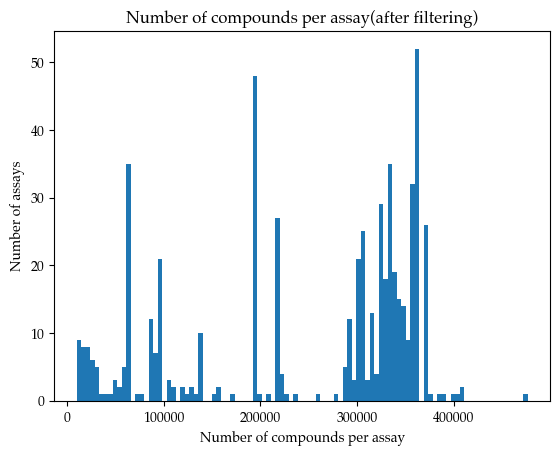

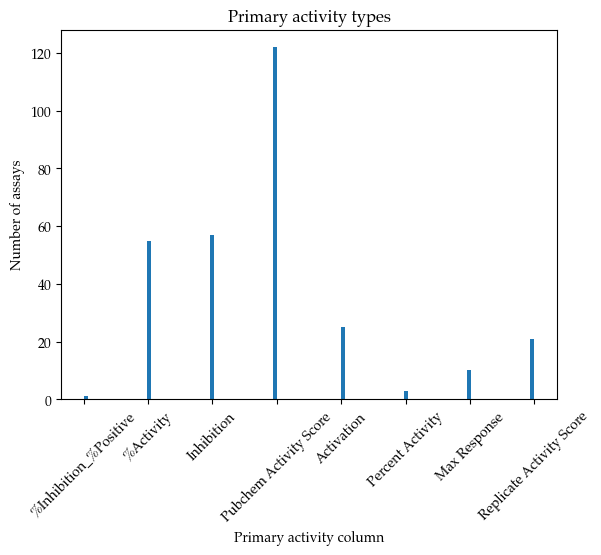

In [12]:
data_process.statistics()


In [ ]:
data_process.compare_to_Helal()

# Analysis

In [76]:
# Load the matrix
matrix_df = pd.read_csv('Data/activity_matrix_100.csv')
matrix_df.head()

,SMILES,1347041,652048,652051,1259415,624414,623870,624415,652067,652126,...,588405,588458,588489,588492,588493,588621,588850,602141,588352,588664
0,CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C...,-38.089760,-0.854682,-0.854682,0.000000,2.996274,-0.000844,-0.370409,0.000000,0.000000,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.260380,-0.372029
1,C1CN(C(C2=C1C3=CC=CC=C3N2)C4=CC(=CC=C4)O)CC5=C...,-19.754667,-0.054001,-0.054001,0.460832,0.190177,0.141050,0.024654,1.223655,1.856588,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.500548,0.058574
2,CN(C)C1=CC2=C(C=C1)C=C3C=CC(=[N+](C)C)C=C3O2.[...,-19.184208,-0.411341,-0.411341,-1.302143,3.293683,0.897816,-0.629843,-0.924189,-0.475099,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,-0.002158,-1.399202
3,CCN=C(N/N=C/C1=CC=C(C=C1)[N+](=O)[O-])SC.I,-17.771549,-0.728801,-0.728801,0.000339,-0.240306,-0.048142,-0.277951,-0.316357,-0.264545,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.265324,0.124896
4,CS(=O)(=O)C1=NSC2=NC(=O)/C(=C\C3=CC=CN3C4=CC=C...,-17.696121,-0.566208,-0.566208,-0.134861,-0.087835,0.093752,0.262823,-0.520670,0.000596,...,-0.06599,-0.045673,-0.030214,NaN,6.467426,10.042401,-0.046669,-0.030226,0.421434,-0.018203


In [114]:
# Load the matrix
matrix_df = pd.read_csv('Data/activity_matrix_filtered_100.csv')
matrix_df.head()

,SMILES,1347041,652048,652051,1259415,624414,623870,624415,652067,652126,...,588405,588458,588489,588492,588493,588621,588850,602141,588352,588664
0,C1CN(C(C2=C1C3=CC=CC=C3N2)C4=CC(=CC=C4)O)CC5=C...,-19.754667,-0.054001,-0.054001,0.460832,0.190177,0.141050,0.024654,1.223655,1.856588,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.500548,0.058574
1,CCN=C(N/N=C/C1=CC=C(C=C1)[N+](=O)[O-])SC.I,-17.771549,-0.728801,-0.728801,0.000339,-0.240306,-0.048142,-0.277951,-0.316357,-0.264545,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.265324,0.124896
2,CCCC[N+]12CCC(CC1)C(=C(C3=CC=CC=C3)C4=CC=CC=C4...,-17.228231,0.020342,0.020342,-0.349246,-0.188391,-0.284631,0.169197,-0.053303,-0.319133,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.539635,0.021982
3,CC1=CC(=C(C(=O)O1)SC2=CC=CC=C2[N+](=O)[O-])OC(...,-17.105682,0.250329,0.250329,0.000000,-0.201930,0.000000,-0.445778,0.000000,0.000000,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.406835,0.103333
4,CCOC(=O)/C(=C\1/C2=CC=CC=C2CC(N1)(C)C)/C.I,-17.089031,0.079203,0.079203,-0.471286,-0.135789,-0.142737,-0.129883,0.071839,-0.342528,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,-0.010399,0.017735


Assays without activity:  Index(['651725', '588492'], dtype='object')
Compounds without activity: All compounds have activity


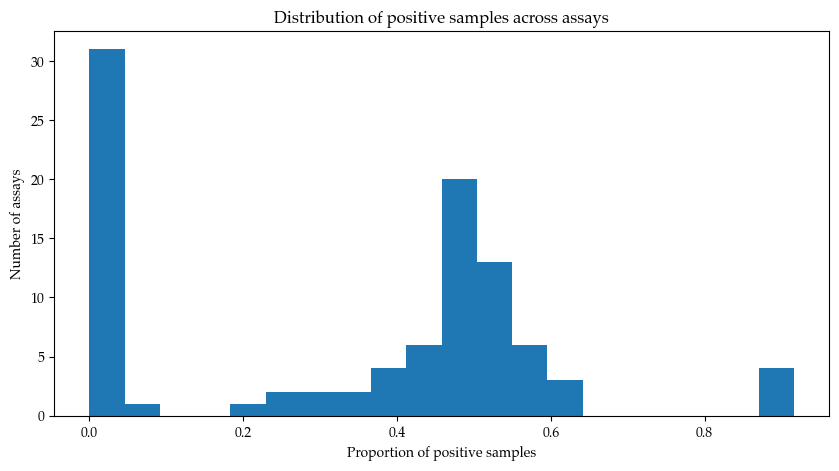

In [30]:
# replace null values with 0
matrix_df.fillna(0, inplace=True)

# check if there is any assay that has zero values across all compounds
pos_assays = torch.ones(len(matrix_df.columns)-1)
for i, assay in enumerate(matrix_df.columns):
    # print(matrix_df[assay])
    if assay=='SMILES':
        continue
    
    if matrix_df[assay].any() != 0:
        pos_assays[i-1] = 0
    
# check if there is any compound that has zero values across all assays
pos_compounds = torch.ones(len(matrix_df))
for i, compound in enumerate(matrix_df['SMILES']):
    # print(matrix_df.iloc[i,1:])
    if matrix_df.iloc[i,1:].any() != 0:
        pos_compounds[i] = 0

# check proportion of positive and negative samples across each assay
pos_ratio = torch.zeros(len(matrix_df.columns)-1)
for i, assay in enumerate(matrix_df.columns):
    # print(matrix_df[assay])
    if assay=='SMILES':
        continue
    # first make column binary
    y = np.where(matrix_df[assay].values>0, 1, 0)
    pos_ratio[i-1] = y.sum()/len(y)

print('Assays without activity: ', matrix_df.columns[1:][np.where(pos_assays.int().numpy()==1)])
if pos_compounds.sum() > 0:
    print('Compounds without activity: ', matrix_df['SMILES'][np.where(pos_compounds.int().numpy()==1)])
else:
    print('Compounds without activity: All compounds have activity')

#plot pos_ratio
plt.figure(figsize=(10,5))
plt.hist(pos_ratio, bins=20)
plt.xlabel('Proportion of positive samples')
plt.ylabel('Number of assays')
plt.title('Distribution of positive samples across assays')
plt.show()


In [9]:
print('Assays with few positive samples: \n', matrix_df.columns[1:][torch.where(pos_ratio<0.2)].values)


Assays with few positive samples: 
 ['493056' '493084' '504660' '651725' '602429' '602438' '602440' '602449'
 '624168' '624204' '624304' '624352' '624354' '651560' '651636' '651699'
 '651999' '602244' '602261' '602274' '602399' '743279' '651647' '504651'
 '588405' '588458' '588489' '588492' '588493' '588621' '588850' '602141']


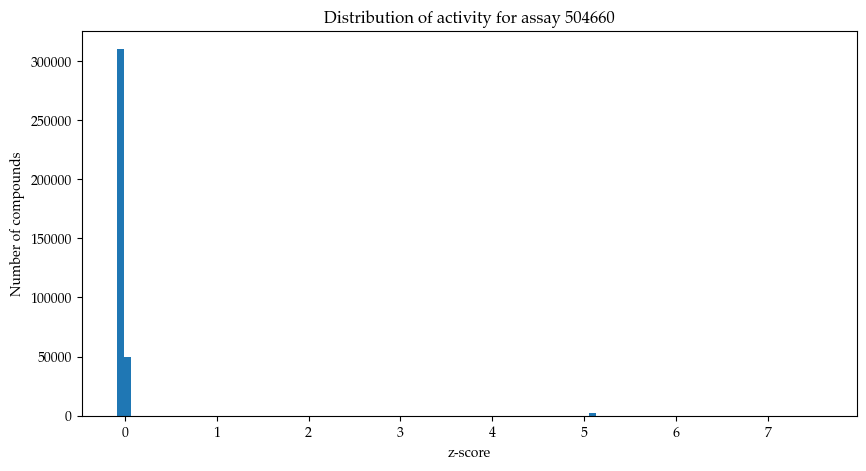

In [43]:
# show the distribution of values for any assay
assay = '504660'
plt.figure(figsize=(10,5))
plt.hist(matrix_df[assay], bins=100)
plt.xlabel('z-score')
plt.ylabel('Number of compounds')
plt.title('Distribution of activity for assay '+assay)
plt.show()

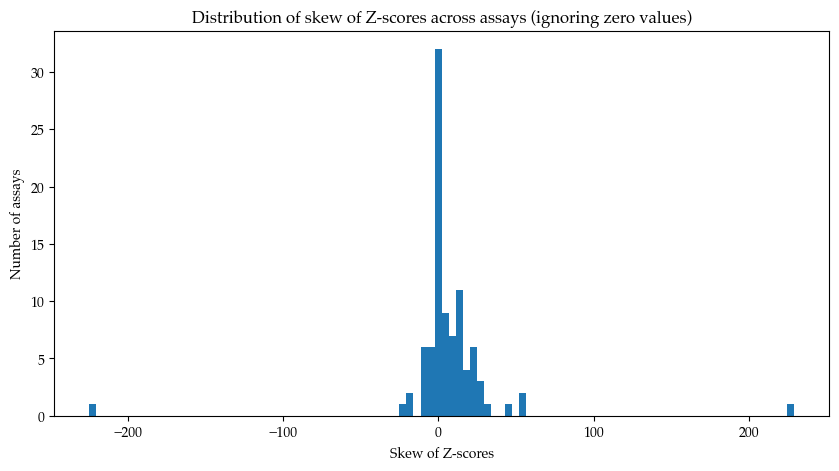

In [54]:
# calcualte the skew of the Z-scores for each assay, while excluding data fields with zero values
skew = []
for assay in matrix_df.columns[1:]:
    skew.append(matrix_df[assay][matrix_df[assay] != 0].skew())
#  A positive skewness indicates a tail on the right side of the distribution (more high positive values), 
# while a negative skewness indicates a tail on the left side (more small negative values). A skewness close to zero suggests a relatively symmetrical distribution.

# plot the skew of the Z-scores for each assay
plt.figure(figsize=(10,5))
plt.hist(skew, bins=100)
plt.xlabel('Skew of Z-scores')
plt.ylabel('Number of assays')
plt.title('Distribution of skew of Z-scores across assays (ignoring zero values)')
plt.show()

### Observations
A number of assays have mainly positive z-scores or mainly negative z-scores.
It seems that all of those have many compoounds with low negative scores and very few with very high positive scores. This indicates that few compounds are strong outliers on one side and shift the mean such that almost all compounds get a negative z-score. The effect of one strong outlier washes out the distribution for all other compound -> is this a valid outlier or noise?

In [11]:
# inspect the distribution of raw values at the primary activity column for any assay
assay = '493056'
# load in the raw data
assay_df = data_process.load_bioassay_data(assay)
assay_df.head()


,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity at 2.0 uM,Compound QC
0,24399413.0,16021061,CCN(C1=CC=CC=C1)C(=O)CN2C3=C(C=CC=N3)N=C2SCC4=...,Inactive,0.0,http://assay.nih.gov/htsws/rest/display/trhr-p...,NaN,-49.9347,QC'd by Sytravon
1,49666778.0,16007740,CCN(CC)S(=O)(=O)C1=CC2=C(C=C1)N(C=C(C2=O)C(=O)...,Inactive,0.0,http://assay.nih.gov/htsws/rest/display/trhr-p...,NaN,-46.7108,QC'd by Chem Div
2,17508421.0,9560081,COC1=C(C=C(C=C1)/C=N/NC(=O)CCN2C3=CC=CC=C3C4=C...,Inactive,0.0,http://assay.nih.gov/htsws/rest/display/trhr-p...,NaN,-38.7301,QC'd by Asinex Ltd.
3,47203674.0,5347956,COC1=CC=CC=C1N2CCN(CC2)/N=C/C3=CC(=C(C=C3)Cl)[...,Inactive,0.0,http://assay.nih.gov/htsws/rest/display/trhr-p...,NaN,-37.9143,QC'd by Asinex Ltd.
4,24786595.0,822260,C1=CC=C(C=C1)C2=NC3=C(N=C(N=C3N=C2C4=CC=CC=C4)...,Inactive,0.0,http://assay.nih.gov/htsws/rest/display/trhr-p...,NaN,-36.8179,QC'd by Specs


In [44]:
# check the mean and std of the Z-scores for each assay
matrix_df.iloc[:, 1:].describe()


,1347041,652048,652051,1259415,624414,623870,624415,652067,652126,652257,...,588405,588458,588489,588492,588493,588621,588850,602141,588352,588664
count,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,...,361913.000000,361913.000000,361913.000000,361913.0,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000,361913.000000
mean,-0.010320,0.001634,0.001646,0.003799,-0.009377,-0.002513,0.000232,-0.000006,0.000336,-0.008428,...,-0.012583,-0.010144,-0.002271,0.0,-0.005361,-0.006602,-0.013304,-0.014002,-0.000923,0.000283
std,0.961930,0.492421,0.492263,0.495204,0.390316,0.459977,0.486743,0.490614,0.492226,0.436976,...,0.446973,0.437493,0.477288,0.0,0.460571,0.425029,0.419830,0.362055,0.490843,0.494536
min,-19.754667,-6.661864,-6.661864,-2.922911,-0.458780,-19.771360,-3.389067,-3.069150,-2.689812,-29.099209,...,-0.115482,-0.079928,-0.052874,0.0,-0.067647,-0.043565,-0.081670,-0.052895,-19.201761,-173.550964
25%,-0.496318,-0.206434,-0.206423,-0.277785,-0.146848,-0.190035,-0.301316,-0.285710,-0.287940,-0.199811,...,-0.065990,-0.045673,-0.030214,0.0,-0.038655,-0.024894,-0.046669,-0.030226,-0.134721,-0.047933
50%,0.037576,0.053535,0.053535,-0.022558,-0.069738,-0.048142,-0.045559,-0.063519,-0.038395,-0.062643,...,-0.065990,-0.045673,-0.030214,0.0,-0.038655,-0.024894,-0.046669,-0.030226,0.088259,0.005974
75%,0.477258,0.225904,0.225904,0.230416,0.037438,0.046454,0.201302,0.186765,0.218948,0.086387,...,-0.065990,-0.045673,-0.030214,0.0,-0.038655,-0.024894,-0.046669,-0.030226,0.276862,0.061841
max,14.194951,13.179916,13.179916,7.320214,20.627007,8.701124,3.975497,7.046585,48.077019,17.055897,...,5.682683,5.473665,8.274290,0.0,9.701138,15.063602,8.035316,12.406676,2.826280,3.539867


In [19]:
data_process.load()

In [ ]:
# inspect the distribution of raw values at the primary activity column for any assay
assay = '493056'
# load in the raw data
assay_df = data_process.load_bioassay_data(assay)
# plot the distribution of primary activity raw values
primary_activity = assay_df[data_process.primary_activity_columns[int(assay)]]

plt.figure(figsize=(10,5))
plt.hist(primary_activity, bins=100)
plt.xlabel('Primary activity raw values')
plt.ylabel('Number of compounds')
plt.title('Distribution of primary activity raw values for assay '+assay)
plt.show()

In [13]:
# count the number of assays for which the primary activity column is 'PUBCHEM_ACTIVITY_SCORE'
count = 0
for AID, column in data_process.primary_activity_columns.items():
    if column == 'PUBCHEM_ACTIVITY_SCORE':
        count += 1
print('Number of assays for which the primary activity column is PUBCHEM_ACTIVITY_SCORE:', count, 'out of', len(data_process.primary_activity_columns))

Number of assays for which the primary activity column is PUBCHEM_ACTIVITY_SCORE: 122 out of 294


In [30]:
# check column names for assays with primary activity column 'PUBCHEM_ACTIVITY_SCORE'
AIDs_PubChemActivityScore = []
for AID in data_process.valid_AIDs:
    if AID not in data_process.primary_activity_columns:
        continue
    if data_process.primary_activity_columns[AID] == 'PUBCHEM_ACTIVITY_SCORE':
        AIDs_PubChemActivityScore.append(AID)
        print(AID, data_process.load_bioassay_data(AID).columns)

743279 Index(['PUBCHEM_SID', 'PUBCHEM_CID', 'PUBCHEM_EXT_DATASOURCE_SMILES',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT', 'Phenotype',
       'Potency', 'Efficacy', 'Analysis Comment',
       'inflammasome-p1_alphalisa-Activity_Score',
       'inflammasome-p1_alphalisa-Curve_Description',
       'inflammasome-p1_alphalisa-Fit_LogAC50',
       'inflammasome-p1_alphalisa-Fit_HillSlope',
       'inflammasome-p1_alphalisa-Fit_R2',
       'inflammasome-p1_alphalisa-Fit_InfiniteActivity',
       'inflammasome-p1_alphalisa-Fit_ZeroActivity',
       'inflammasome-p1_alphalisa-Fit_CurveClass',
       'inflammasome-p1_alphalisa-Excluded_Points',
       'inflammasome-p1_alphalisa-Max_Response',
       'inflammasome-p1_alphalisa-Activity at 11.50 uM',
       'inflammasome-p1_alphalisa-Activity at 57.50 uM', 'Compound QC'],
      dtype='object')
651725 Index(['PUBCHEM_SID', 'PUBCHEM_CID', 'PUBCHEM_EXT_DATASOURCE_SMILES',
  

In [ ]:
# check that primary activity finder is working for assays that previously failed
t = 0
for assay in AIDs_PubChemActivityScore:
    assay_df = data_process.load_bioassay_data(assay)
    #print(data_process.find_primary_activity_column(assay_df))
    primary_activity = data_process.find_primary_activity_column(assay_df)[1]
    data_process.primary_activity_columns[assay] = primary_activity
    if primary_activity == 'PUBCHEM_ACTIVITY_SCORE':
        t += 1
        print(assay)

In [31]:
# inspect the distribution of raw values at the primary activity column for any assay
assay = '488922'
# load in the raw data
assay_df = data_process.load_bioassay_data(assay)
print(data_process.find_primary_activity_column(assay_df))
assay_df.head()


(True, 'PUBCHEM_ACTIVITY_SCORE')


,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Bscore_Ratio,Bscore_Intensity
0,14732488.0,135476833,CCCOC1=CC=CC=C1N/C(=N/C2=NC(=CC(=N2)C)C)/NC(=O...,Active,99.0,http://www.jhicc.org,0.0,-26.615,-1.533
1,14728444.0,1589806,CCCCOC1=C(C2=C(C=C1)C(=CC(=O)O2)C)OCCCC,Active,95.0,http://www.jhicc.org,0.0,-25.207,-0.251
2,17414613.0,2911354,CC1=CC(=C(N1C2=CC(=C(C=C2)NC3CCCCC3)[N+](=O)[O...,Active,94.0,http://www.jhicc.org,0.0,-24.929,-0.355
3,56322574.0,5709759,CCN\1C2=CC=CC=C2S/C1=C\C=C\C3=[N+](C4=CC=CC=C4...,Active,92.0,http://www.jhicc.org,0.0,-24.114,-5.337
4,46501243.0,480785,CC(=CCC1=C(C=CC(=C1O)C2COC3=C(C(=CC(=C3C2=O)O)...,Active,91.0,http://www.jhicc.org,0.0,-23.789,0.814


In [123]:
# filter promiscuous compounds
z_threshold = 3
hit_threshold = 0.05
data_process.filter_promiscuous_compounds(z_threshold, hit_threshold)

No. of promiscuous compounds filtered: 2377 (15325.620530079934% of compounds)


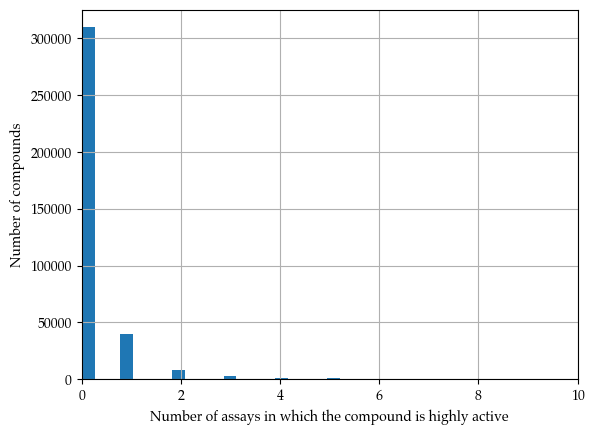

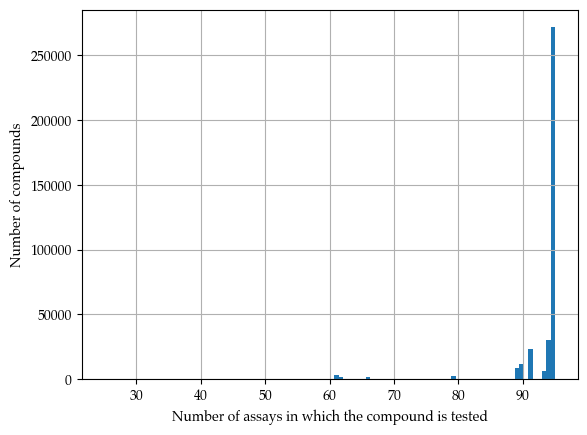

In [37]:
data_process.num_active.hist(bins=100)
plt.xlabel('Number of assays in which the compound is highly active')
plt.ylabel('Number of compounds')
plt.xlim(0, 10)
plt.show()

data_process.num_tested.hist(bins=100)
plt.xlabel('Number of assays in which the compound is tested')
plt.ylabel('Number of compounds')
plt.show()


## Filter inactive compounds
- Those that are not active across any assays -> could just be noise

In [125]:
data_process.filter_inactive_compounds(z_threshold=0.5)

No. of inactive compounds filtered: 98 (0.03 % of compounds)
